## ARTIFICIAL INTELLIGENCE ON LEGAL LANGUAGE PROCESSING: USING DEEP LEARNING TO FOUND THE REGULATORY LAW FRAMEWORK FOR THE THIRD SECTOR

### Mauricio Barros de Jesus - mauriciobajesus@gmail.com
### McCormick & Ryan (2019) inspired the source code.  Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from - https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [3]:
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from torch.optim import Adam
from tqdm import tqdm
import re
import unicodedata
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from pathlib import Path
from sklearn.utils import resample, shuffle
import random

import seaborn as sns

from sklearn.metrics import mean_absolute_error, matthews_corrcoef, auc, roc_curve
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, accuracy_score, f1_score, recall_score 

import time
import datetime

import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
## Load BERT tokenizer. We choose BERTimbau Base https://huggingface.co/neuralmind/bert-base-portuguese-cased
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

In [7]:
BASE_DIR = Path(os.path.abspath('')).resolve()
batch_size = 4
max_length_bert = 512

In [7]:
df_aval = pd.read_excel(Path(os.path.join(BASE_DIR, 'dataset','train_test_val','df_test_12092022_v2.xlsx')))
df_aval = shuffle(df_aval)

In [8]:
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased', #"bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.load_state_dict(torch.load(os.path.join(BASE_DIR,'models',f'model_state.save_3'))["model_state_dict"])
device = torch.device("cuda")
model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [9]:
def predictSentence(sentences,labels):
    # Report the number of sentences.
    #print('Number of test sentences: {:,}\n'.format(len(sentences)))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 512,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks, labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    
    #print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels, pred_vals = [], [], []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)


        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        pred_vals.append(pred_flat)

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    #print('DONE.')
    #return predictions
    return {"pred_vals":pred_vals,"predictions":predictions,"true_labels":true_labels}

In [10]:
def runBootstrap(nrIter = 10):
  
    listBootstrapF1Score = []
    listBootstrapAUC = []

    for i in range(0,nrIter):
        dfTmp = df_aval.sample(n=int(len(df_aval)/2), replace=False)
        sentences = dfTmp["text"].to_list()
        labels = dfTmp["cat"].to_list()

        resp = predictSentence(sentences,labels)
        y_pred = np.concatenate(resp["predictions"], axis=0)
        y_pred = np.argmax(y_pred, axis=1).flatten()
        y_test = np.concatenate(resp["true_labels"], axis=0)
        
        listBootstrapF1Score.append(f1_score(y_test, y_pred))
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        listBootstrapAUC.append(auc(fpr, tpr))

    return [listBootstrapF1Score,listBootstrapAUC]


In [11]:
listBootstrap = runBootstrap(nrIter = 1000)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [12]:
arrF1 = np.asarray(listBootstrap[0])
arrAUC = np.asarray(listBootstrap[1])

In [13]:
dfBootstrap = pd.DataFrame()
dfBootstrap["f1_mesure"] = arrF1
dfBootstrap["auc"] = arrAUC
dfBootstrap.to_excel(Path(os.path.join(BASE_DIR,'dataset','results','bootstrap_16092022_v1.xlsx')))


In [8]:
dfBootstrap = pd.read_excel(Path(os.path.join(BASE_DIR,'dataset','results','bootstrap_16092022_v1.xlsx')))

In [14]:
arrF1 = np.asarray(dfBootstrap["f1_mesure"].to_list())
arrAUC = np.asarray(dfBootstrap["auc"].to_list())

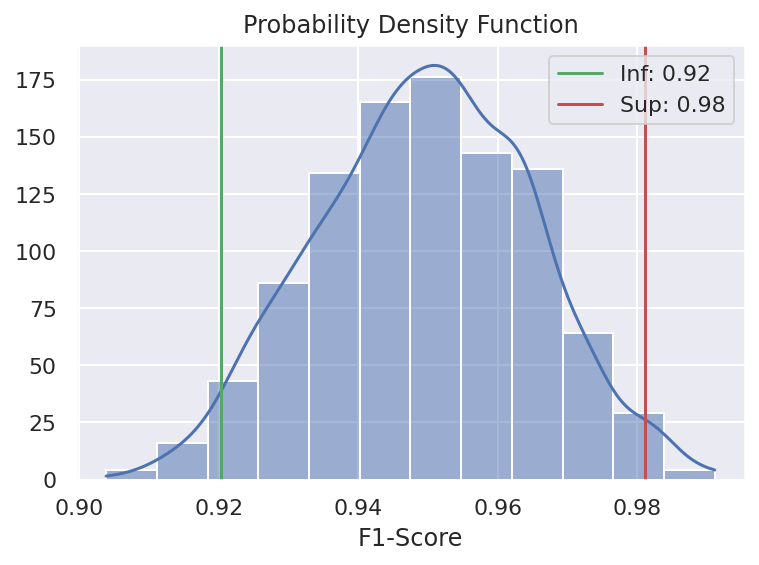

In [17]:
low = 'Inf: %.2f' % (1 * np.percentile(arrF1,[2.5])[0])
upper = 'Sup: %.2f' % (1 * np.percentile(arrF1,[97.5])[0])
sns.set(rc={'figure.figsize':(6,4)})
sns.histplot(data=dfBootstrap, x="f1_mesure", kde=True,bins=12)
plt.axvline(x=np.percentile(arrF1,[2.5]), ymin=0, ymax=1,label=low,c='g')
plt.axvline(x=np.percentile(arrF1,[97.5]), ymin=0, ymax=1,label=upper,c='r')
plt.title("Probability Density Function")
plt.xlabel("F1-Score")
plt.ylabel("")
plt.legend()
plt.savefig(Path(os.path.join(BASE_DIR,'dataset','results','confidence_interval_f1.png')),bbox_inches='tight', dpi=600)


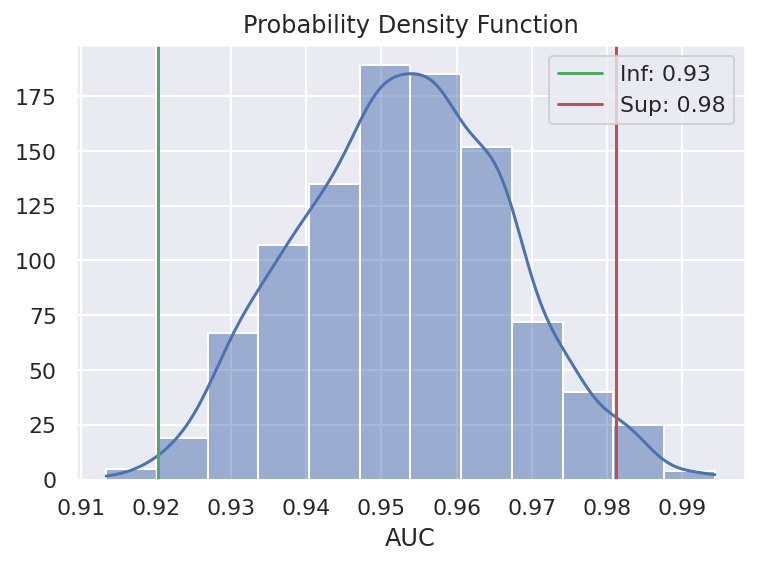

In [18]:
low = 'Inf: %.2f' % (1 * np.percentile(arrAUC,[2.5])[0])
upper = 'Sup: %.2f' % (1 * np.percentile(arrAUC,[97.5])[0])
sns.set(rc={'figure.figsize':(6,4)})
sns.histplot(data=dfBootstrap, x="auc", kde=True, bins=12)
plt.axvline(x=np.percentile(arrF1,[2.5]), ymin=0, ymax=1,label=low,c='g')
plt.axvline(x=np.percentile(arrF1,[97.5]), ymin=0, ymax=1,label=upper,c='r')
plt.title("Probability Density Function")
plt.xlabel("AUC")
plt.ylabel("")
plt.legend()
plt.savefig(Path(os.path.join(BASE_DIR,'dataset','results','confidence_interval_auc.png')),bbox_inches='tight', dpi=600)
